### Spectral Clustering Example.

This is a modification of TomAugspurger's Spectral Clustering example (noted in https://github.com/dask/dask-ml/issues/151) which has been modified to process GeoTIFF's

I also followed the example from https://www.planet.com/docs/api-quickstart-examples/step-2-download/ to download a geotif file.

In addition to `dask-ml`, we'll use `rasterio` to read the data and `matplotlib` to plot the figures.  I'm just working on my laptop, so we could use either the threaded or distributed scheduler. I'll use the distributed scheduler for the diagnostics.

In [1]:
%matplotlib inline

In [2]:
import rasterio
import matplotlib.pyplot as plt
import dask.array as da
from dask_ml.cluster import SpectralClustering
from dask.distributed import Client

In [3]:
import os

fname = 'Midwest_Mosaic.tif'
url = 'https://github.com/ebo/pangeo-tutorials/raw/master/data/Landsat_Mosaics/'+fname

if not os.path.exists(fname):
    import urllib.request
    print("downloading test image file '%s'"%fname)
    urllib.request.urlretrieve(url, fname)

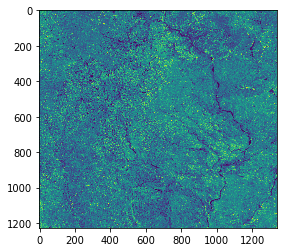

In [4]:
from rasterio import windows
with rasterio.open(fname, 'r', chunks={'x':100, 'y':100}) as src:
    arr = src.read(1)
    profile = src.profile
    tags = src.tags()

arr = arr.astype(float)

# Rescale for the clustering algorithm
arr = (arr - arr.mean()) / arr.std()

# Subsample to the upper-left quadrant for viewing
plt.imshow(arr[:2500, :2500]);

In [5]:
client = Client(memory_limit=4e9, n_workers=1, threads_per_worker=4)
client

Client Scheduler: tcp://127.0.0.1:38909 Dashboard: http://127.0.0.1:40378/status,Cluster Workers: 1 Cores: 4 Memory: 4.00 GB


We'll reshape the image to be how dask-ml / scikit-learn expect it: `(n_samples, n_features)` where n_features is 1 in this case. Then we'll persist that in memory. We still have a small dataset at this point. The large dataset, which dask helps us manage, is the intermediate `n_samples x n_samples` array that spectral clustering operates on.

In [6]:
X = da.from_array(arr.reshape(-1, 1), chunks=100_000)
X = client.persist(X)

And we'll fit the estimator.

In [7]:
clf = SpectralClustering(n_clusters=4, random_state=0,
                         kmeans_params={'init_max_iter': 5})

In [8]:
%time clf.fit(X)

/home/jldavid3/anaconda3/envs/pangeo/lib/python3.6/site-packages/dask/array/core.py:2176: UserWarning: Increasing number of chunks by factor of 16
  (nparts / max_parts))
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 4.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 4.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 4.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 4.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 4.60s.  This is often caused by long-running GIL-holding functions or moving l

CPU times: user 4min 46s, sys: 5.7 s, total: 4min 52s
Wall time: 9min 5s


SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          kmeans_params={'init_max_iter': 5}, n_clusters=4,
          n_components=100, n_init=10, n_jobs=1, n_neighbors=10,
          persist_embedding=False, random_state=0)

distributed.core - WARNING - Event loop was unresponsive in Scheduler for 4.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


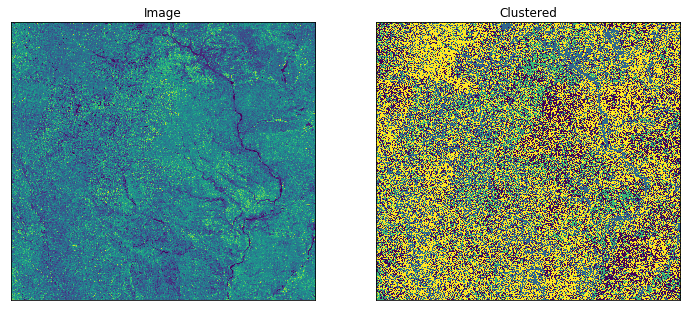

In [9]:
labels = clf.assign_labels_.labels_.compute()

c = labels.reshape(arr.shape)

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(arr[:2500, :2500])
axes[1].imshow(c[:2500, :2500]);

axes[0].set_title("Image")
axes[1].set_title("Clustered")

for ax in axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [10]:
# save the results back as a GeoTIFF
outfile = os.path.splitext(fname)[0]+"_out.tif"

# create the output as a single band, not as the 3 that came in
profile['count'] = 1

with rasterio.open(outfile,'w',chunks={'x':100, 'y':100}, **profile) as dst:
    # skip the band only tags and propegate the image associated tags
    dst.update_tags(**tags)
    
    # output the classified array
    dst.write(c.astype(profile['dtype']), 1)

/home/jldavid3/anaconda3/envs/pangeo/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)
